### Chess Games
To begin, we need to prepare the data that is readily available for us in `games.csv`. There are 6 columns that will be kept which are turns, white_rating, black_rating, rated, winner and first_move. From all of these columns, we will have to parse the moves column to receive the first_move and then use one hot encoding to successfully run our algorithms on the categorical data. 

Number of entries: 18132
Number of features: 6
   turns  white_rating  black_rating  rated winner  first_move_Nc3  \
1     16          1322          1261   True  black           False   
2     61          1496          1500   True  white           False   
3     61          1439          1454   True  white           False   
4     95          1523          1469   True  white           False   
6     33          1520          1423   True  white           False   
8     66          1439          1392   True  black           False   
9    119          1381          1209   True  white           False   

   first_move_Nf3  first_move_Nh3  first_move_a3  first_move_a4  ...  \
1           False           False          False          False  ...   
2           False           False          False          False  ...   
3           False           False          False          False  ...   
4           False           False          False          False  ...   
6           False           Fals

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


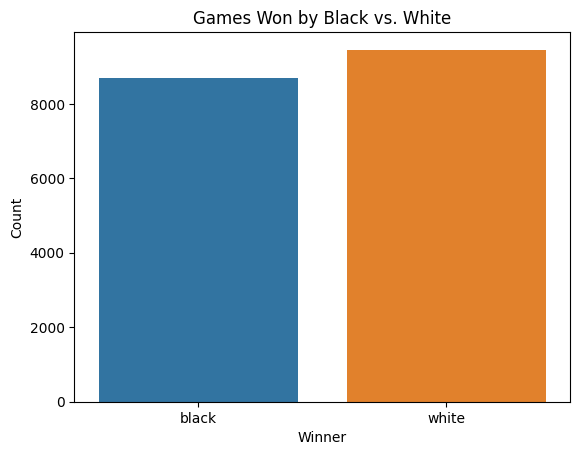

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import constants
# Load your dataset
d = pd.read_csv('./datasets/games.csv')
# filtered_data = d[(d['turns'] >= 15) | (d['victory_status'] != 'draw') | (d['winner'] != 'draw')].copy()# Use .copy() to ensure you are working on a copy
filtered_data = d[(d['turns'] >= 15) & (d['winner'] != 'draw')].copy()

# Define the target column and set random_state
target_column = 'winner'

# parse out the first move
filtered_data['moves'] = filtered_data['moves'].str.split()
filtered_data['first_move'] = filtered_data['moves'].str[0]
# filtered_data['second_move'] = filtered_data['moves'].str[1] #TODO: If I want to include the second move

# List the columns to keep - and drop the rest 
columns_to_keep = ["turns", "white_rating", "black_rating", "rated", "winner", "first_move"]
data = filtered_data[columns_to_keep]

# Create one-hot encoding for the "first_move" column, and drop the first_move column
one_hot_encoded = pd.get_dummies(data['first_move'], prefix='first_move', drop_first=True)
data_encoded = pd.concat([data, one_hot_encoded], axis=1)
data_encoded = data_encoded.drop(columns=['first_move'])

# Set the X and y for the data 
X = data_encoded.drop(columns=[target_column])
y = data_encoded[target_column]

# Print out data and stats to ensure correct
num_entries = data.shape[0]
print("Number of entries:", num_entries)
num_features = data.shape[1]
print("Number of features:", num_features)
print(data_encoded.head(7))
counts = data_encoded['winner'].value_counts()
print("counts", counts)
sns.countplot(data=data_encoded, x='winner')
plt.xlabel('Winner')
plt.ylabel('Count')
plt.title('Games Won by Black vs. White')
plt.show()

Next we must split the data into the training and tests set. 

In [2]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=constants.TEST_SIZE, random_state=constants.RANDOM_STATE)

### Decision Tree
Train using the values for a decision tree, and then plot the learning curve using the cross validation value set globally.

In [3]:
from dt import dt

# Create a GridSearchCV object for hyperparameter tuning
param_grid = {
    'max_depth': [8,9,7,6,5],  # You can include 'None' for unlimited depth
    'min_samples_split': [2, 5, 3, 13],
    'min_samples_leaf': [1, 5, 9]
}

best_dt_model, best_dt_params = dt(X_train, X_test, y_train, y_test, param_grid)


Best Hyperparameters: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}
cross validation: 5
Accuracy: 0.6410256410256411
Classification Report:
               precision    recall  f1-score   support

       black       0.69      0.45      0.54      1726
       white       0.62      0.82      0.70      1901

    accuracy                           0.64      3627
   macro avg       0.65      0.63      0.62      3627
weighted avg       0.65      0.64      0.63      3627



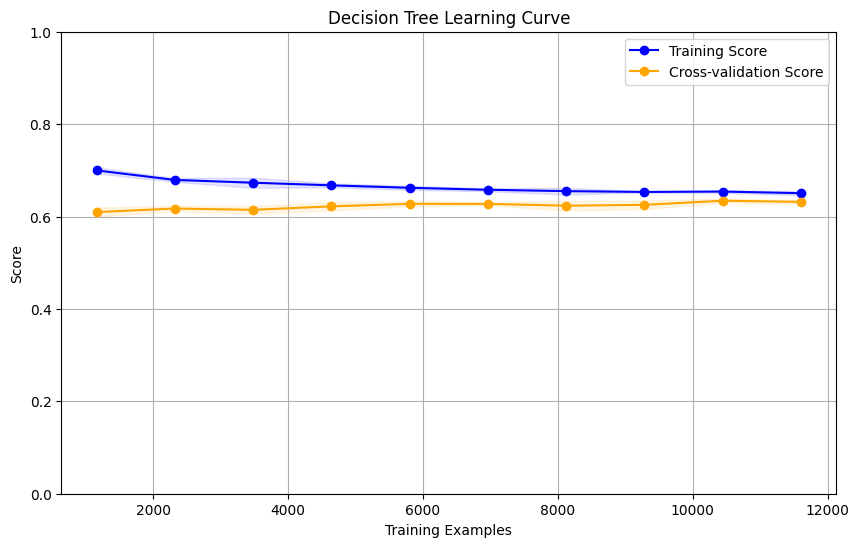

In [4]:
from graphs import plot_learning_curve
plot_learning_curve(best_dt_model, X_train, y_train, scoring='accuracy', title="Decision Tree Learning Curve")

### Neural Networks

In [5]:
from nn import nn

param_grid = {
    'hidden_layer_sizes': [(32,), (64,), (128,), (256,), (512,)],
    'learning_rate_init': [0.001, 0.01, 0.1, 0.0001]
}

best_nn_model, best_nn_params = nn(X_train, X_test, y_train, y_test, param_grid)

Best Hyperparameters: {'hidden_layer_sizes': (512,), 'learning_rate_init': 0.01}
Classification Report:
               precision    recall  f1-score   support

       black       0.62      0.71      0.66      1726
       white       0.70      0.61      0.65      1901

    accuracy                           0.65      3627
   macro avg       0.66      0.66      0.65      3627
weighted avg       0.66      0.65      0.65      3627



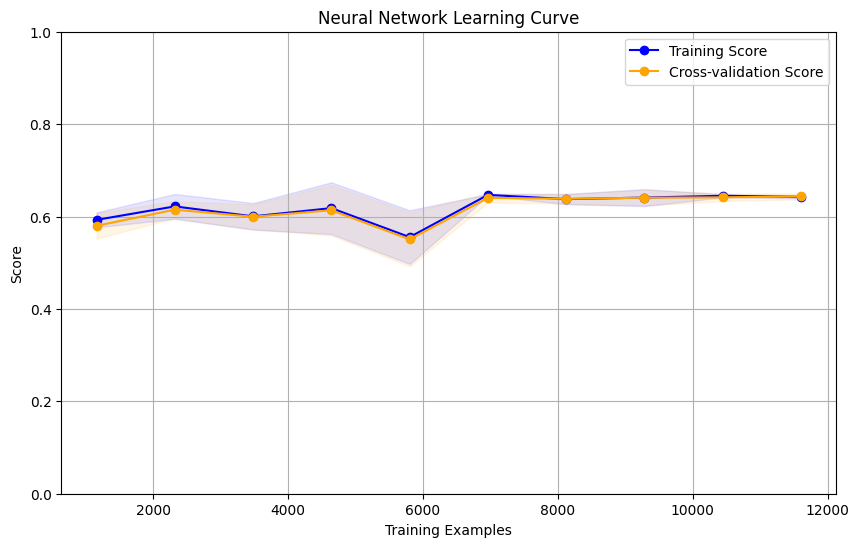

In [6]:
plot_learning_curve(best_nn_model, X_train, y_train, scoring='accuracy', title="Neural Network Learning Curve")

### K-Nearest Neighbors

In [8]:
from knn import knn

param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['distance'],
    'p': [1, 2]
}

best_knn_model, best_knn_params = knn(X_train, X_test, y_train, y_test, param_grid)

Best Hyperparameters: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Classification Report:
               precision    recall  f1-score   support

       black       0.64      0.62      0.63      1726
       white       0.67      0.69      0.68      1901

    accuracy                           0.66      3627
   macro avg       0.65      0.65      0.65      3627
weighted avg       0.66      0.66      0.66      3627



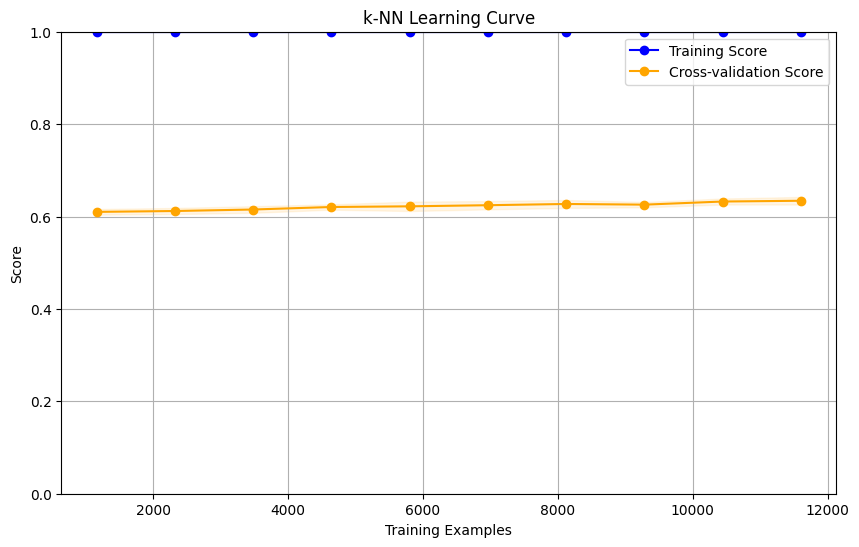

In [9]:
from graphs import plot_learning_curve
plot_learning_curve(best_knn_model, X_train, y_train, scoring='accuracy', title="k-NN Learning Curve")

### Boosted Decision Tree Classifier

In [10]:
from dt import ada_boosted_dt

# Define the parameter grid for AdaBoost
param_grid = {
    'base_estimator__max_depth': [None, 10, 20, 30],  # Adjust max_depth as needed
    'n_estimators': [50, 100, 200],  # Number of Decision Trees in the ensemble
    'learning_rate': [0.01, 0.1, 1.0]
}

best_bdt_model, best_bdt_params = ada_boosted_dt(X_train, X_test, y_train, y_test, param_grid)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/

Best AdaBoost Decision Tree Hyperparameters: {'base_estimator__max_depth': 10, 'learning_rate': 0.1, 'n_estimators': 50}
Classification Report:
               precision    recall  f1-score   support

       black       0.86      0.83      0.84      1726
       white       0.85      0.87      0.86      1901

    accuracy                           0.85      3627
   macro avg       0.85      0.85      0.85      3627
weighted avg       0.85      0.85      0.85      3627



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/

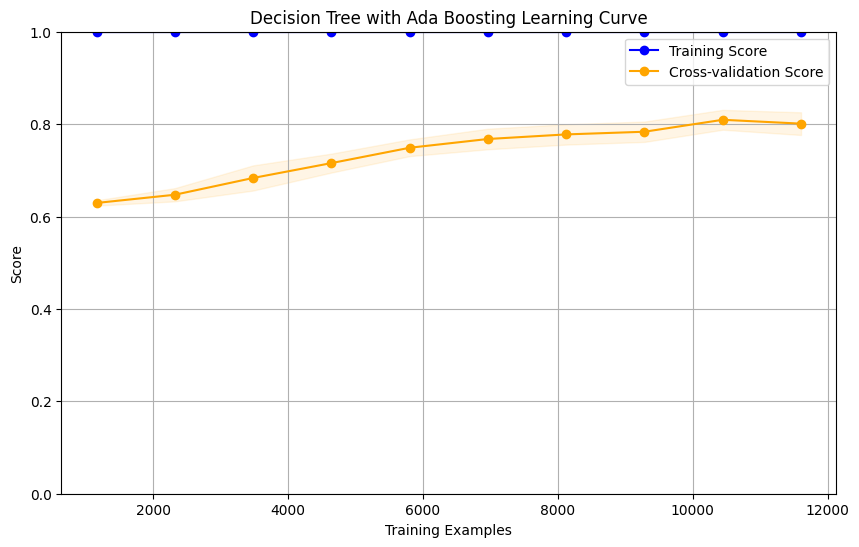

In [11]:
from graphs import plot_learning_curve
plot_learning_curve(best_bdt_model, X_train, y_train, scoring='accuracy', title="Decision Tree with Ada Boosting Learning Curve")

### Support Vector Machine


In [12]:
from svm import svm
from sklearn.preprocessing import StandardScaler

# We need to scale the data before we pass it to the SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Set the param grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1, 1],
    'degree': [2, 3, 4]
}

# Pass the scaled data to the svm
best_svm_model, best_svm_params = svm(X_train_scaled, X_test_scaled, y_train, y_test, param_grid)


running v2
Best Hyperparameters: {'C': 10, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
Classification Report:
               precision    recall  f1-score   support

       black       0.52      0.49      0.50      1726
       white       0.56      0.59      0.57      1901

    accuracy                           0.54      3627
   macro avg       0.54      0.54      0.54      3627
weighted avg       0.54      0.54      0.54      3627



In [13]:
from graphs import plot_learning_curve
plot_learning_curve(best_svm_model, X_train_scaled, y_train, scoring='accuracy', title="SVM Learning Curve")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
